In [7]:
import os
import re
import rasterio
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def process_zonal_stats_from_directory(raster_directory, gdf):
    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Get all .tif files starting with "CA" in the given directory
    raster_files = glob(os.path.join(raster_directory, "CA*.tif"))
    print(raster_files)
    
    # Loop through each raster file in the directory
    for raster_path in raster_files:
        print(f"Processing raster: {raster_path}")
        
        # Check CRS of the raster
        with rasterio.open(raster_path) as src:
            raster_crs = src.crs
            raster_epsg = raster_crs.to_string()  # Extract the EPSG code as a string
            print(f"Raster CRS EPSG: {raster_epsg}")

            # Extract the transform and pixel size
            transform = src.transform
            pixel_width = transform[0]  # The pixel width is at position (0, 0)
            pixel_height = abs(transform[4])  # The pixel height is at position (1, 1)
            print(f'Pixel Height: {pixel_height}\nPixel Width: {pixel_width}')

        # Verify the initial CRS of the GeoDataFrame
        initial_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
        print(f'Initial CRS EPSG: {initial_epsg}')

        # Reproject the GeoDataFrame to match the raster's CRS
        gdf = gdf.to_crs(raster_crs)

        # Verify the reprojected CRS of the GeoDataFrame
        reprojected_epsg = gdf.crs.to_string()  # Extract the EPSG code as a string
        print(f'Reprojected CRS EPSG: {reprojected_epsg}')

        # Perform zonal statistics (mean, sum, etc.) between the reprojected GeoDataFrame and raster
        zonal_stats_results = zonal_stats(
            gdf,  # Reprojected shapefile (GeoDataFrame)
            raster_path,
            stats="count",
            geojson_out=True
        )

        # Convert the list of features into a GeoDataFrame
        zonal_stats_gdf = gpd.GeoDataFrame.from_features(zonal_stats_results)

        # Calculate NCA_Frac (NCA Fraction) using count and pixel area
        pixel_area = pixel_width * pixel_height
        zonal_stats_gdf['CA_Frac'] = (zonal_stats_gdf['count'] * pixel_area) / zonal_stats_gdf['Shape_Area']

        # Extract the decimal number from the raster filename using regex
        raster_filename = os.path.basename(raster_path)  # Get the filename from the path
        
        # Regex to extract the decimal number before '_mm'
        match = re.search(r'(\d+\.\d+)_mm', raster_filename)
        if match:
            decimal_number = match.group(1)  # Extracted decimal number (e.g., 1.000 or 22.400)
        else:
            raise ValueError(f"Could not find decimal number in filename: {raster_filename}")

        # Create the column name using the extracted decimal number
        column_name = f'NCAMapper_FCA_{decimal_number}mm'  # Example: NCAMapper_1.000

        # Rename the 'CA_Frac' column to the new name
        zonal_stats_gdf[column_name] = zonal_stats_gdf['CA_Frac']
        zonal_stats_gdf.drop('CA_Frac', axis=1, inplace=True)

        # Extract relevant columns ('seg_nhm' and the new column)
        subset_df = zonal_stats_gdf[['seg_nhm', column_name]]

        # Set 'seg_nhm' as the index
        subset_df.set_index('seg_nhm', inplace=True)

        # Convert the index to integer
        subset_df.index = subset_df.index.astype(int)

        # Append the result to the results DataFrame
        results_df = pd.concat([results_df, subset_df], axis=1)

    return results_df

### Inputs

In [4]:
st_mary= pd.read_csv('../../geospacial/misc/stmary_seg', header= None)

milk_shapefile= gpd.read_file('../../geospacial/shapefiles/milk_shapefile/Milk_Shapefile.shp')

managed_lakes= gpd.read_file('../../geospacial/depressions/managed_lakes.gpkg')

raster_directory= './ncamapper_outputs/NCAmapper_output/'

### Format Shapefile

In [5]:
# Ensure both shapefiles have the same CRS (coordinate reference system)
if milk_shapefile.crs != managed_lakes.crs:
    managed_lakes = managed_lakes.to_crs(milk_shapefile.crs)

# Perform the difference operation to trim smm_shapefile by removing the parts overlapping with managed_lakes
trimmed_smm = milk_shapefile.geometry.apply(lambda geom: geom.difference(managed_lakes.unary_union))

# Create a new GeoDataFrame with the trimmed geometries
trimmed_smm_gdf = milk_shapefile.copy()
trimmed_smm_gdf['geometry'] = trimmed_smm

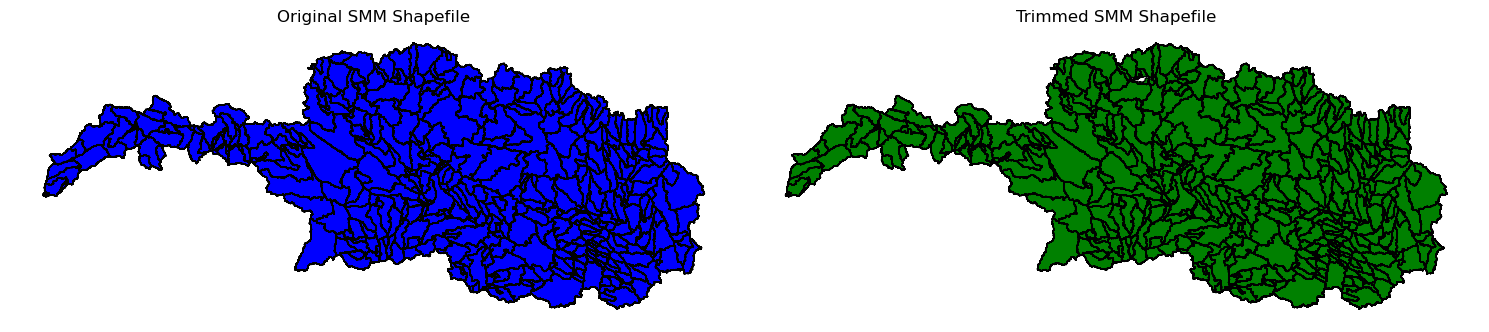

In [8]:
# Plotting to ensure trimming worked
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot the original shapefile
milk_shapefile.plot(ax=ax[0], color='blue', edgecolor='k')
ax[0].set_title('Original SMM Shapefile')
ax[0].set_axis_off()

# Plot the trimmed shapefile
trimmed_smm_gdf.plot(ax=ax[1], color='green', edgecolor='k')
ax[1].set_title('Trimmed SMM Shapefile')
ax[1].set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()

### Calculate Zonal Statistics

In [9]:
ncamapper_CA= process_zonal_stats_from_directory(raster_directory, trimmed_smm_gdf)

['./ncamapper_outputs/NCAmapper_output\\CA_1_0yr_0.010_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_2_5yr_3.530_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_3_25yr_8.040_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_4_50yr_13.750_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_5_75yr_23.200_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_6_95yr_46.790_mm.tif', './ncamapper_outputs/NCAmapper_output\\CA_7_100yr_194.870_mm.tif']
Processing raster: ./ncamapper_outputs/NCAmapper_output\CA_1_0yr_0.010_mm.tif
Raster CRS EPSG: EPSG:26912
Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:4326
Reprojected CRS EPSG: EPSG:26912
Processing raster: ./ncamapper_outputs/NCAmapper_output\CA_2_5yr_3.530_mm.tif
Raster CRS EPSG: EPSG:26912
Pixel Height: 31.217319422283374
Pixel Width: 19.87737948875997
Initial CRS EPSG: EPSG:26912
Reprojected CRS EPSG: EPSG:26912
Processing raster: ./ncamapper_outputs/NCAmapper_output\CA_3_25yr_8.040_mm.tif
Raste

In [10]:
ncamapper_CA

,NCAMapper_FCA_0.010mm,NCAMapper_FCA_3.530mm,NCAMapper_FCA_8.040mm,NCAMapper_FCA_13.750mm,NCAMapper_FCA_23.200mm,NCAMapper_FCA_46.790mm,NCAMapper_FCA_194.870mm
seg_nhm,,,,,,,
58242,0.202681,0.369737,0.514982,0.619474,0.700077,0.762060,0.847350
58243,0.149757,0.301199,0.483547,0.678319,0.765344,0.870606,0.979163
58244,0.312902,0.336041,0.379605,0.446120,0.536529,0.664181,0.993247
58245,0.767147,0.777641,0.794302,0.826343,0.952105,0.994159,1.001769
58246,0.304195,0.310906,0.318776,0.353674,0.383142,0.938941,0.999402
...,...,...,...,...,...,...,...
58671,0.000000,0.000000,0.000000,0.000331,0.003167,0.003421,0.750412
58672,0.017659,0.021398,0.024013,0.041272,0.053878,0.064716,0.183598
58673,0.000028,0.000076,0.000205,0.000451,0.001495,0.003497,0.010504


In [11]:
ncamapper_CA.to_csv('./ncamapper_outputs/zonal_statistics_NCAMapper.csv')